In [51]:

import numpy as np
# import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go

In [52]:
N = 100000
n_stations = 150

In [53]:
np.random.seed(34)

In [54]:
stations = np.random.uniform(low= 0, high=N, size=(n_stations, 2))


In [55]:
plane_route = np.array([[x,int(0.3 * x)] for x in range(0,int(N/2),1000 )] + [[x, x - int(0.7 * N/2)] for x in range(int(N/2),N+1,1000 )])

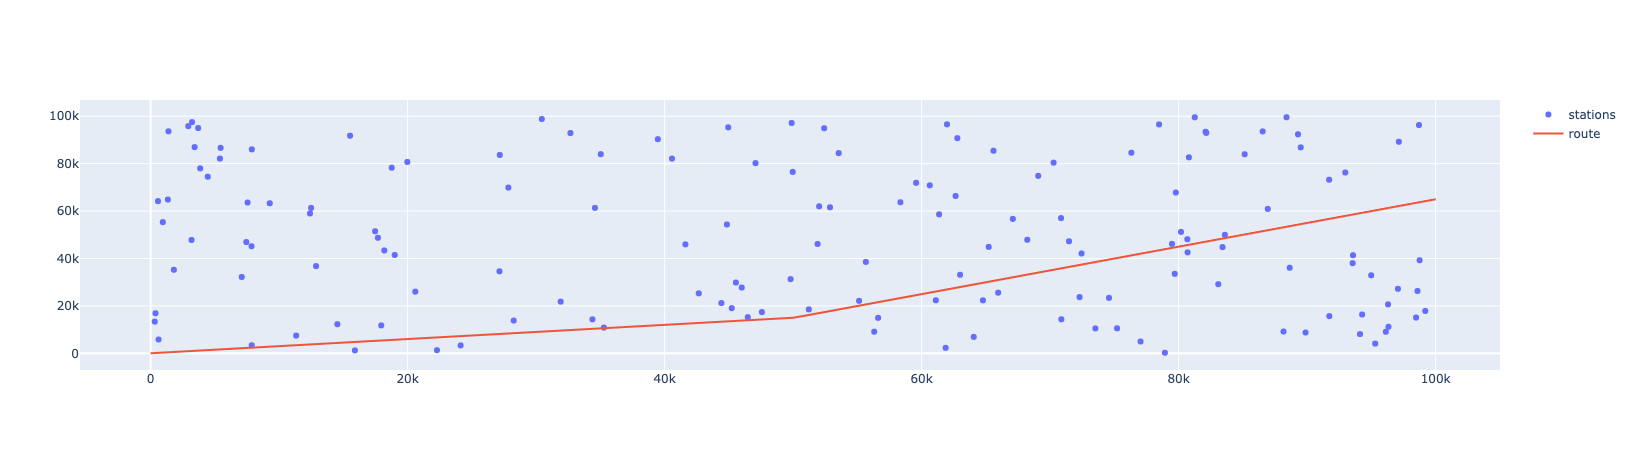

In [56]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                    mode='markers',
                    name='stations'))
fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                    mode='lines',
                    name='route'))


In [57]:
def find_closest_point(point, stations):
    d = np.linalg.norm(stations - point, axis=1)
    return np.argmin(d)

In [58]:
def closest_path(route, stations):
    res = [stations[find_closest_point(p, stations), :] for p in route]
    return res

In [59]:
path_long = np.array(closest_path(plane_route, stations))
path = np.unique(path_long, axis=0)

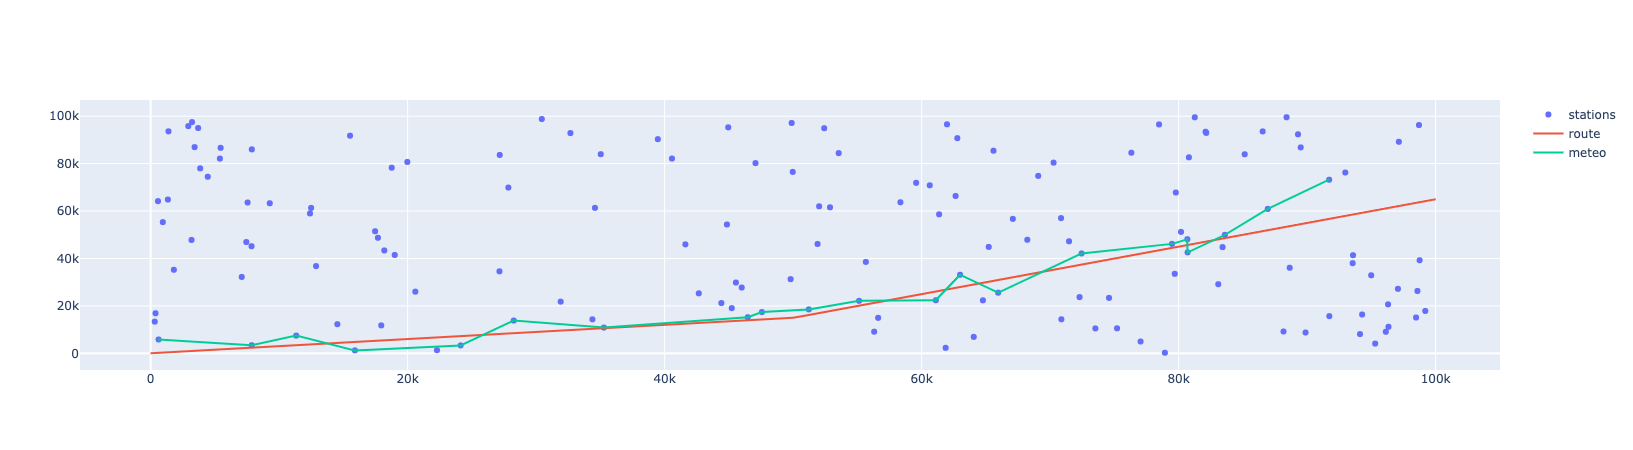

In [60]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                    mode='markers',
                    name='stations'))
fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                    mode='lines',
                    name='route'))
fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
                    mode='lines',
                    name='meteo'))

In [61]:
from scipy.spatial.distance import cosine


In [62]:
def compute_penalty(path):
    return sum([cosine(path[i+1]-path[i], path[i]- path[i-1]) for i in range(1,len(path)-1)])



In [63]:
def compute_distances(path, route):
    return np.array([np.linalg.norm(path-r,axis=1)**2 for r in route])
distances = compute_distances(path, plane_route)
distance_dict = {i:min(distances[:, i]) for i in range(len(path))}

In [64]:
filter_indices = [np.argmin(distances[:, i]) for i in range(len(path))]
plane_route_meteo = np.take(plane_route, filter_indices, axis=0)

In [65]:
from collections import namedtuple
import math
import time
Result = namedtuple('Result', ['fpl', 'ogimet'])

# Point proxy to use my python functions
class Point(object):
    def __init__(self, value, name=None, pid=None):
        self.value = value
        self.pid = pid
        if name is None:
            self.name = '{0}_{1}'.format(*value)
        else:
            self.name = name
        self.x = value[0]
        self.y = value[1]

    def xtd_to(self, segment):
        """
        Given the segment AB, computes cross track error
        :param segment: (Point, Point) the segment AB
        :return: float the cross track error
        """
        p1 = segment[0]
        p2 = segment[1]
        x_diff = p2.x - p1.x
        y_diff = p2.y - p1.y
        num = (y_diff*self.x - x_diff*self.y + p2.x*p1.y - p2.y*p1.x)
        den = math.sqrt(y_diff**2 + x_diff**2)
        if den == 0:
            return 0
        return num / den

    def distance_to(self, other):
        x_diff = other.x - self.x
        y_diff = other.y - self.y
        return math.sqrt(y_diff**2 + x_diff**2)


# Python algorithm from editolido library
def find_strategic(start, end, results, l=0, initial_sign=1):
    """
    Find point you can not suppress without increasing xtd
    :param start: int
    :param end: int
    :param results: [Result]
    :return:
    """
    # search in reverse order to stop at the latest point in the route direction
    # in segment [i, j] we try to remove inner elements by checking the xtd
    previous_sign = initial_sign
    sign = lambda a: 1 - (a<0)
    for k in range(end - 1, start, -1):
        # xtd from ogimet point to fpl segment
        o_xtd = results[k].ogimet.xtd_to(
            (results[k].fpl, results[k + 1].fpl)
        )
        new_sign = sign(o_xtd)
        # xtd from fpl point to ogimet segment
        f_xtd = results[k].fpl.xtd_to(
            (results[start].ogimet, results[end].ogimet)
        )
        penalty = 0 if ((new_sign == previous_sign)) else abs(o_xtd) * l
        previous_sign = new_sign
        if abs(f_xtd) > abs(o_xtd) + penalty:
            return k, new_sign
    return None, initial_sign


def find_best_xtd(start, end, results):
    best = None
    best_xtd = 0
    for k in range(start + 1, end):
        # o_xtd = results[k].ogimet.xtd_to(
        #     (results[k].fpl, results[k + 1].fpl)
        # )
        xtd = results[k].fpl.xtd_to((results[k - 1].ogimet, results[k + 1].ogimet))
        if best is None or abs(xtd) < abs(best_xtd):
            best = k
            best_xtd = xtd
    # print('best', results[best].ogimet.pid, "({0})".format(best))
    return best, 1 - (best_xtd < 0)


def filter_by_xtd(results, max_distance=0, l=0):
    """
    Here we keep significant ogimet points.
    By significant, I mean points which increase the xtd if missing.
    The algorithm is recursive, if route is A B C D E F
    and ogimet route found is A B'C'D'E'F
    We try to suppress B', if successful we try to suppress C' and so on
    For example if B', C' and E' are not relevant the loop
    will try to suppress B' and C', then it will keep D' and
    start again from D' to suppress E' and keep F
    At the end we try again (recursion) until the route size is constant.
    For information a typical NAT route will reduce from 26 to 15 points
    and a flight to NRT will end with 26 points (starting from 79)
    :param results: [Result]
    :return: [Result]
    """
    res = [results[0]]
    i = -1
    previous_sign = 1  # on departure we expect xtd = 0
    while i < (len(results) - 1):
        i += 1
        j = i + 2
        # we try to remove many consecutive points until it fails
        while j <= len(results) - 1:
            d = 0
            if max_distance > 0:
                d = results[i].fpl.distance_to(results[j].fpl)
            if max_distance <= 0 or (max_distance > 0 and d <= max_distance):
                k, previous_sign = find_strategic(i, j, results, l=l, initial_sign=previous_sign)
            elif d > max_distance and j > i + 1:  # j > i + 1 is to limit recursion
                k, previous_sign = find_best_xtd(i, j, results)
            elif d > max_distance:
                k = j
                if (j > 1):
                    o_xtd = results[j-1].ogimet.xtd_to(
                        (results[j-1].fpl, results[j].fpl)
                    )
                    previous_sign = 1 - (o_xtd < 0)
                else:
                    previous_sign = 1
            if k is None:
                j += 1  # no significant point yet, try to extend to next
            else:
                # a significant point was found, store it
                if results[k].ogimet.name not in [o.name for _, o in res]:
                    res.append(results[k])
                i = k - 1  # will start at k on next round
                break
    res.append(results[-1])
    # recursion works, so try it until there is no change
    if len(res) < len(results):
        return filter_by_xtd(res, max_distance=max_distance, l=l)
    else:
        return res



ordered_indices = np.argsort(plane_route_meteo[:,0], axis=0)
plane_route_meteo = plane_route_meteo[ordered_indices]
new_path = path[ordered_indices]
new_path = path
start = time.process_time()
ogimet_results = [Result(Point(plane_route_meteo[i]), Point(new_path[i])) for i in range(len(path))]
ogimet_results = filter_by_xtd(ogimet_results, l=0.3)
end = time.process_time()

strategics = [[r.ogimet.x, r.ogimet.y] for r in ogimet_results]
strategics_np = np.array(strategics)

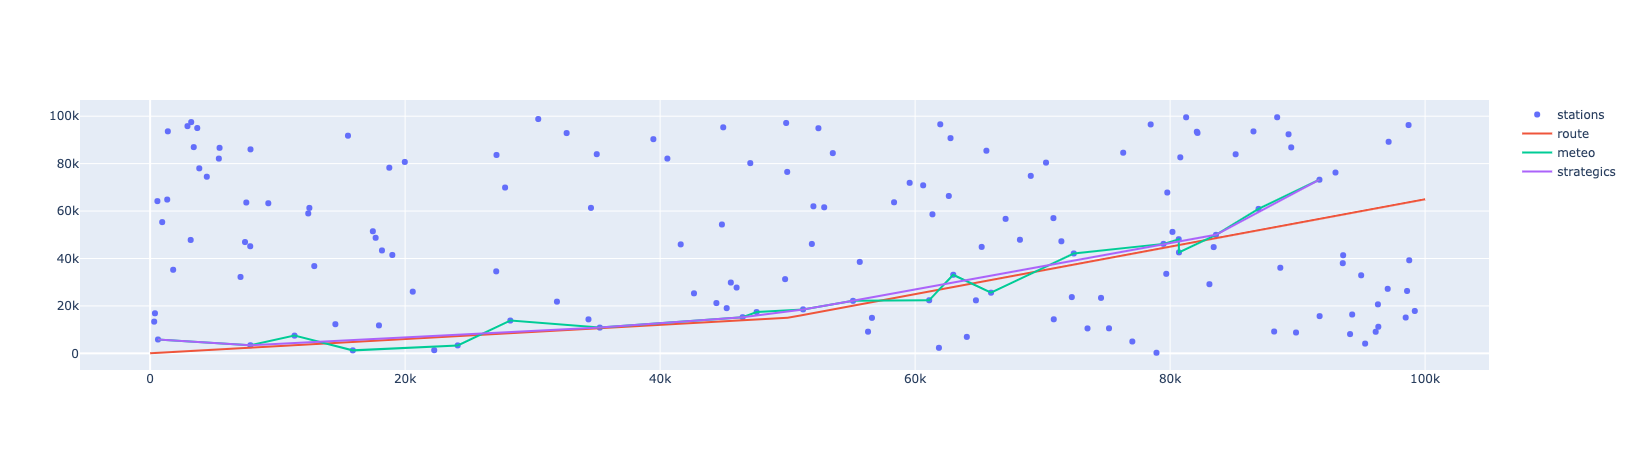

In [66]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                    mode='markers',
                    name='stations'))
fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                    mode='lines',
                    name='route'))
fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
                    mode='lines',
                    name='meteo'))
fig.add_trace(go.Scatter(x=strategics_np[:,0], y=strategics_np[:,1],
                    mode='lines',
                    name='strategics'))

In [67]:
def l2_loss(distances, indices):
    dd = distances[:, indices]
    return sum(dd.min(axis=1))


In [68]:
def global_loss(path, route, distances, indices, l):
    return (np.log(l2_loss(distances, indices)) + l*compute_penalty(path[indices]))/len(indices)


In [69]:
from itertools import combinations
from tqdm import tqdm

In [70]:
def find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l):
    min_loss_path = path
    for k in tqdm(range(min_points_to_remove+1)):
        min_loss = N
        if len(min_loss_path) <= len(path) - min_points_to_remove:
            break
        for p in combinations(range(1,len(path)-1), k):
            indices = [i for i in range(len(path)) if i not in p]
            new_loss = global_loss(path, plane_route, distances, indices, l)
            if new_loss < min_loss and len(indices) >= len(path) - min_points_to_remove:
                min_loss = new_loss
                min_loss_path = path[indices]

    best_loss = global_loss(min_loss_path, plane_route, distances, [i for i in range(len(min_loss_path))], l )
    losses = [best_loss]
    current_path = min_loss_path
    best_path = min_loss_path
    print("length after min_removal", len(current_path))
    for k in tqdm(range(max_points_to_remove-min_points_to_remove+1)):
        for p in combinations(range(1,len(current_path)-1), k):
            indices = [i for i in range(len(current_path)) if i not in p]
            new_loss = global_loss(current_path, plane_route, distances, indices, l)
            if new_loss < best_loss:
                best_loss = new_loss
                losses.append(new_loss)
                best_path = current_path[indices]
    print("length after optimization", len(best_path))
    return best_path, losses

In [71]:
def plot_res(stations, plane_route, path, best_paths):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                        mode='markers',
                        name='stations'))
    # fig.add_trace(go.Scatter(x=plane_route_meteo[:,0], y=plane_route_meteo[:,1],
    #                 mode='markers',
    #                 name='meteo route points'))
    fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                        mode='lines',
                        name='route'))
    fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
                    mode='lines',
                    name='meteo'))
    fig.add_trace(go.Scatter(x=strategics_np[:,0], y=strategics_np[:,1],
            mode='lines',
            name='strategics'))
    for i, best_path in enumerate(best_paths):
        fig.add_trace(go.Scatter(x=best_path[:,0], y=best_path[:,1],
                            mode='lines',
                            name='meteo_opt_' + str(i)))
    return fig

In [72]:
min_points_to_remove = 0
max_points_to_remove = 2
best_paths = []
print("Meteo route length:", len(path))
print("strategics length: ", len(strategics))
print('strategics processing time: {0:.3f}ms'.format((end-start)*1000))
for l in [0.1, 1, 10]:
    opt_path = find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l)
    best_paths.append(opt_path[0])
    print(len(best_paths[-1]), opt_path[1])

100%|██████████| 3/3 [00:00<00:00, 31.12it/s]


Meteo route length: 21
strategics length:  8
strategics processing time: 0.715ms
length after min_removal 21
length after optimization 21
21 [1.0886482074845876]
length after min_removal 21
length after optimization 19
19 [1.6715965661895917, 1.637629800648503, 1.5555914653515674, 1.5137293004494963, 1.4568097182866282]
length after min_removal 21
length after optimization 19
19 [7.5010801532396325, 7.220877629793842, 6.700334154535781, 5.854888983278698, 5.473041614431978, 4.925354674567251, 4.354135545333267]


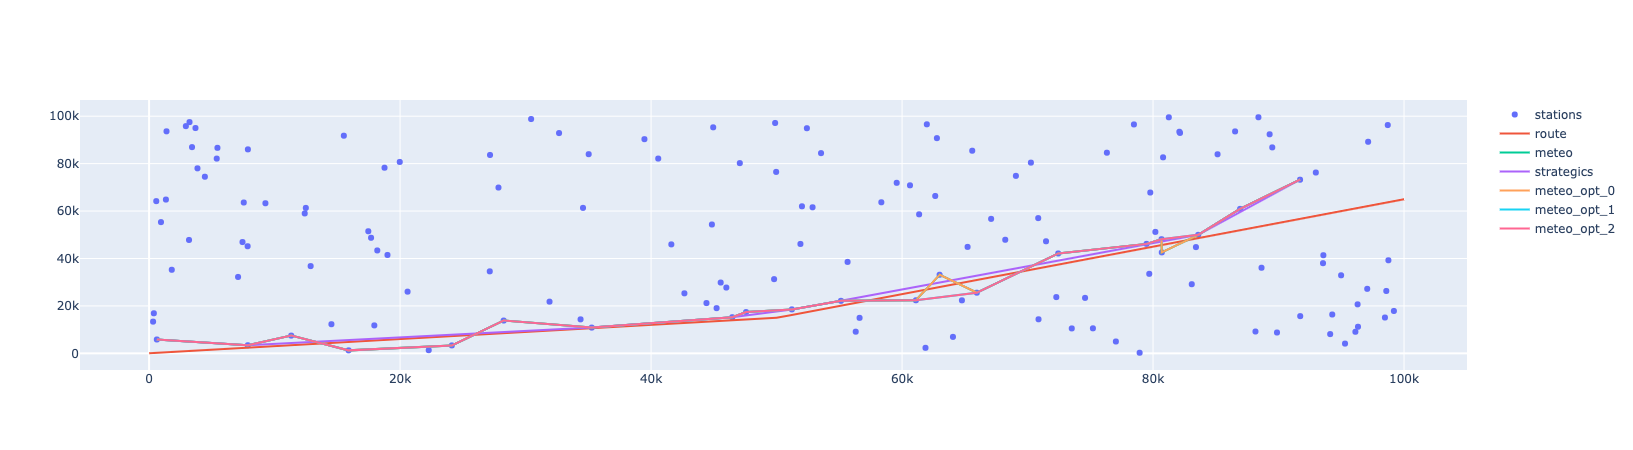

In [73]:
plot_res(stations, plane_route, path, best_paths)

In [74]:
# print('strategics route length', len(strategics))
# min_points_to_remove = len(path) - len(strategics)
# max_points_to_remove = min_points_to_remove + 2
# best_paths = []
# print("Meteo route length:", len(path))
# for l in [0.1, 1, 10]:
#     opt_path = find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l)
#     best_paths.append(opt_path[0])
#     print(len(best_paths[-1]), opt_path[1])


In [75]:
# plot_res(stations, plane_route, path, best_paths)